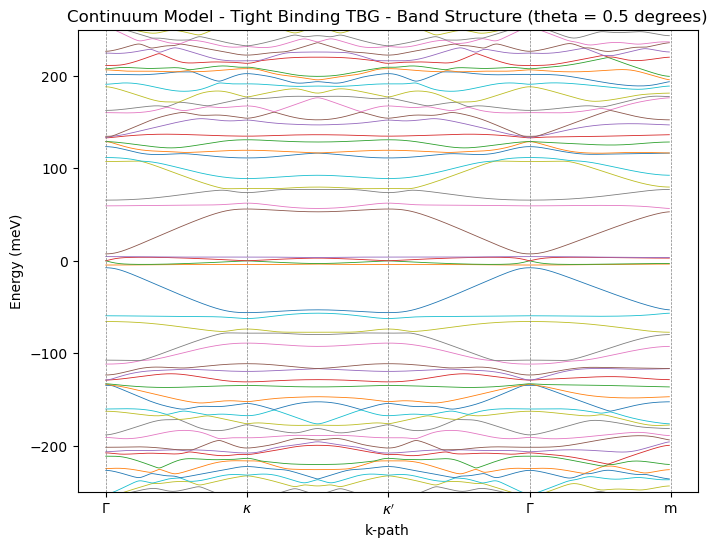

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

""" PARAMETERS """
# Parameters
n_layers = int(3)
sublattices = int(2)
dof = int(n_layers * sublattices)
d = 1.42 # C-C Distance
a = np.sqrt(3)*d  # lattice constant
hv = 6582.12  # Fermi Velocity + Plank's Constant meV*angstrom

valley = 1  # valley index

npts = 100
N = 4  # truncate range of Q mbz grid about k points

w_ab = 110  # AB Tunneling Amplitudes
ratio = 0.0
w_aa = ratio * w_ab  # New w_aa based on ratio

# Define real-space lattice vectors
a1 = np.array([a, 0])
a2 = np.array([a / 2, a * np.sqrt(3) / 2])
real_space_lattice_vectors = [a1, a2]

# Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex) # Identity
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex) # Pauli X
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex) # Pauli Y

# Function for rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

def kronecker_delta_momentum(q_diff, q_target):
    return np.all(np.abs(q_diff - q_target) < tolerance)

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

def stacking_config(phi1, phi2, phi3):
    return np.array([phi1, phi2, phi3])

phi_ABA = stacking_config(0, 2 * np.pi / 3, -2 * np.pi / 3)
phi_AAA = stacking_config(0,0,0)

# Calculate reciprocal lattice vectors between layers 1 and 2
reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
b1, b2 = reciprocal_vectors    

# Define tunneling matrix using Pauli matrices
def tunneling_matrix(w_aa, w_ab, c3_angle,phi):
    return (w_aa * sigma_0 + w_ab *  ( (np.cos(c3_angle) * sigma_x + np.sin(c3_angle) * sigma_y) ) )  * np.exp(-1j * phi)

# Construction of the relevant Tunneling matrices # phi = lattice relaxation const to control/modulate the stacking configuration
# check placement of exp factor inside or outside?
# Check angles phi_AAA, -phiAAA or reverse?
T1_12 = tunneling_matrix(w_aa, w_ab, 0,phi_ABA[0])
T2_12 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3,phi_ABA[1])
T3_12 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3,phi_ABA[2])


T1_23 = tunneling_matrix(w_aa, w_ab, 0,-phi_ABA[0])
T2_23 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3,-phi_ABA[1])
T3_23 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3,-phi_ABA[2])

# Generate moiré grid
siteN = (2 * N + 1) ** 2
dim_ham = siteN * dof
Nlist = np.arange(-N,N+1)
Nlistones = np.ones(2*N+1)
nlist = np.kron(Nlist,Nlistones) 
mlist =np.kron(Nlistones,Nlist) 




L = np.zeros((siteN, 2))
k = 0
for i in np.arange(2 * N + 1):
    for j in np.arange(2 * N + 1):
        L[k, 0] = i - N
        L[k, 1] = j - N
        k += 1

def klines(A, B, numpts):
    return np.array([np.linspace(A[jj], B[jj], numpts) for jj in range(len(A))]).T

# Function to create the special k-path for TBG
def moire_kline(npts, delk):
    # Define the Moiré Brillouin zone endpoints
    K2 = delk * np.array([0, 0])
    kappa = delk * np.array([np.sqrt(3)/2, -1/2])
    kappa_prime = delk  * np.array([np.sqrt(3)/2, 1/2])
    K2 = delk * np.array([0, 0])
    m = delk * np.array([np.sqrt(3)/2, 0])

    
    # Generate the k-path segments
    kline1 = klines(K2, kappa, npts)
    kline2 = klines(kappa, kappa_prime , npts)
    kline3 = klines(kappa_prime , K2, npts)
    kline4 = klines(K2, m , npts)
    
    
    # Labels for each segment
    klabels = [r'$\Gamma$', r'$\kappa$', r'$\kappa^{\prime}$', r'$\Gamma$', r'm']
    kcoord = np.array([0, (npts - 1), 2 * (npts - 1), 3 * (npts - 1),4 * (npts - 1)])
    
    # Concatenate the path segments
    return np.concatenate((kline1[:-1, :], kline2[:-1, :], kline3[:-1, :],kline4[:-1, :])), kcoord, klabels

def Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m, Q_grid_x, Q_grid_y):
    # Initialize Hamiltonian
    H = np.zeros((dim_ham, dim_ham), dtype=np.complex128)

    diag = np.diag(np.ones(2*N),1) 
    diag_N = np.eye(2*N+1)
    kd1 = np.kron(diag_N,diag_N) 
    kd2 = np.kron(diag,diag_N) 
    kd3 = np.kron(diag_N,diag) 
    
    q1x = kx + Q_grid_x + K1m[0]
    q1y = ky + Q_grid_y + K1m[1]
    q2x = kx + Q_grid_x + K2m[0]
    q2y = ky + Q_grid_y + K2m[1]
    q3x = kx + Q_grid_x + K3m[0]
    q3y = ky + Q_grid_y + K3m[1]

    # Dirac Intralayer Hopping Hamiltonian Construction
    H_1 =  hv * ( np.kron(np.diag(q1x),sigma_x) + np.kron(np.diag(q1y), sigma_y) )
    H_2 =  hv * ( np.kron(np.diag(q2x),sigma_x) + np.kron(np.diag(q2y), sigma_y) )
    H_3 =  hv * ( np.kron(np.diag(q3x),sigma_x) + np.kron(np.diag(q3y), sigma_y) )

    
    T12 = np.kron(kd1,T1_12) + np.kron(kd2,T2_12) + np.kron(kd3,T3_12)
    T23 = np.kron(kd1,T1_23) + np.kron(kd2,T2_23) + np.kron(kd3,T3_23)

    H[:2*siteN,:2*siteN] = H_1 
    H[2*siteN:4*siteN,2*siteN:4*siteN] = H_2 
    H[4*siteN:,4*siteN:] = H_3
    H[:2*siteN,2*siteN:4*siteN] = T12 
    H[2*siteN:4*siteN,:2*siteN] = T12.conj().T 
    H[2*siteN:4*siteN,4*siteN:] = T23 
    H[4*siteN:, 2*siteN:4*siteN] = T23.conj().T 

    
    # Calculate and return sorted eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)  # Use eigvalsh for Hermitian matrix eigenvalues
    return np.sort(eigenvalues)


def calc_bands_HTTG(theta_deg):
    # Convert theta to radians and recalculate delk for the new theta
    theta_rad = np.radians(theta_deg)
    theta_values = [theta_rad, 0.0, -theta_rad]
    delk = 8 * np.pi * np.sin(theta_rad / 2) / (a * 3)
    
    # Recalculate rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    """# Recalculate mBZ vectors G1m and G2m for the given theta
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2
    q0 = (2/3) * G1m + (1/3) * G2m"""

    q0  =  delk * np.array([0,-1]) 
    q1  =  delk * np.array([-np.sqrt(3),1])/2 
    q2  =  delk * np.array([np.sqrt(3),1])/2 
    G1m =  delk * np.array([-np.sqrt(3),3])/2  ## Reciprocal lattice vecotor 1 
    G2m =  delk * np.array([np.sqrt(3),3])/2   ## Reciprocal lattice vector 2 

    K2m = np.array([0,0]) # This will be [0, 0]
    K3m = K2m + q0
    K1m = K2m - q0

    Q_grid_x = nlist*G1m[0] + mlist*G2m[0] 
    Q_grid_y = nlist*G1m[1] + mlist*G2m[1] 

    delk = np.linalg.norm(q0)  # Moire Modulated reciprocal spacing constant for the mBZ


    # Call the function to plot the band structure for the current theta
    plot_band_structure(Hamiltonian, npts, delk, theta_deg, K1m, K2m, K3m, G1m, G2m, Q_grid_x, Q_grid_y)


        

def plot_band_structure(Hamiltonian, npts, delk, theta_deg,K1m, K2m, K3m, G1m, G2m, Q_grid_x, Q_grid_y):
    k_path, kcoord, klabels = moire_kline(npts, delk)
    num_bands = dof * siteN  # Adjust based on Hamiltonian size for TBG
    E = np.zeros((len(k_path), num_bands))
    
    # Evaluate Hamiltonian eigenvalues at each k-point along the path
    for idx, k_point in enumerate(k_path):
        kx, ky = k_point  # Extract kx and ky from the path point
        E[idx, :] = Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m, Q_grid_x, Q_grid_y)  # Directly store sorted eigenvalues

    # Plotting the band structure
    plt.figure(figsize=(8, 6))
    for i in range(num_bands):
        plt.plot(E[:, i], lw=0.6)
   
    # Customize plot
    plt.xticks(kcoord, klabels)  # Set tick positions and labels
    plt.xlabel("k-path")
    plt.ylabel("Energy (meV)")
    for xc in kcoord:
        plt.axvline(x=xc, color='gray', linestyle='--', linewidth=0.5)
    plt.title(f"Continuum Model - Tight Binding TBG - Band Structure (theta = {theta_deg} degrees)")
    plt.ylim(-250, 250)
    plt.show()


# Main loop to generate plots for each angle and save as images
angles = [0.50]

for theta in angles:
    calc_bands_HTTG(theta)



